In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------ Core algorithm ------------------------------

def resample_to_5min(solar_15min: np.ndarray) -> np.ndarray:
    """
    Linearly interpolate a 15-min series to 5-min resolution (3x points).
    """
    solar_15min = np.asarray(solar_15min, dtype=float)
    n15 = solar_15min.size
    if n15 < 2:
        raise ValueError("solar_15min must have at least 2 points")
    x_old = np.arange(n15)
    x_new = np.linspace(0, n15 - 1, n15 * 3)  # 3x more points (5-min)
    solar_5min = np.interp(x_new, x_old, solar_15min)
    return solar_5min


def minimal_ramped_hydro(
    L: np.ndarray,
    U: np.ndarray,
    ramp_up_step: float,
    ramp_dn_step: float,
    initial_hydro_mw: float | None = None
):
    """
    Compute the minimal hydro schedule h[t] that satisfies:
        - Lower bound: h[t] >= L[t]
        - Upper bound: h[t] <= U[t]
        - Ramp limits: h[t] - h[t-1] <= ramp_up_step and h[t-1] - h[t] <= ramp_dn_step
      If initial_hydro_mw is provided, also enforce for t=0:
        h[0] ∈ [max(L[0], initial - ramp_dn_step), min(U[0], initial + ramp_up_step)]

    Returns (feasible: bool, h: np.ndarray or None)
    """
    L = np.asarray(L, dtype=float)
    U = np.asarray(U, dtype=float)
    n = L.size
    if n == 0:
        return False, None

    h = np.maximum(L, 0.0).copy()

    # Initialize t=0 within bounds
    if initial_hydro_mw is None:
        if h[0] > U[0]:
            return False, None
        h[0] = np.clip(h[0], L[0], U[0])
    else:
        lb0 = max(L[0], initial_hydro_mw - ramp_dn_step)
        ub0 = min(U[0], initial_hydro_mw + ramp_up_step)
        if lb0 > ub0:
            return False, None
        h[0] = lb0  # minimal feasible start

    # Forward pass: enforce ramp up/down to future
    for t in range(1, n):
        lb = max(L[t], h[t-1] - ramp_dn_step)  # cannot drop too fast
        ub = min(U[t], h[t-1] + ramp_up_step)  # cannot rise too fast
        if lb > ub:
            return False, None
        h[t] = lb  # minimal feasible respecting forward ramp & bounds

    # Iteratively reconcile with backward ramp constraints
    changed = True
    iters = 0
    max_iters = 10
    while changed and iters < max_iters:
        changed = False
        iters += 1

        # Backward pass: enforce that we can ramp from t to t+1
        for t in range(n - 2, -1, -1):
            lb = max(L[t], h[t+1] - ramp_up_step)      # else ramp up too steep at t->t+1
            ub = min(U[t], h[t+1] + ramp_dn_step)      # else ramp down too steep at t->t+1
            if lb > ub:
                return False, None
            new_ht = h[t]
            # We'd like minimal schedule, so prefer the smallest value within [lb, ub],
            # but not lower than ensuring forward feasibility.
            new_ht = max(lb, min(h[t], ub))
            if abs(new_ht - h[t]) > 1e-12:
                h[t] = new_ht
                changed = True

        # Forward consistency after backward adjustments
        for t in range(1, n):
            lb = max(L[t], h[t-1] - ramp_dn_step)
            ub = min(U[t], h[t-1] + ramp_up_step)
            if lb > ub:
                return False, None
            new_ht = max(lb, min(h[t], ub))
            if abs(new_ht - h[t]) > 1e-12:
                h[t] = new_ht
                changed = True

    # Final verification
    if np.any(h < L - 1e-9) or np.any(h > U + 1e-9):
        return False, None
    dh = np.diff(h)
    if np.any(dh > ramp_up_step + 1e-9) or np.any(-dh > ramp_dn_step + 1e-9):
        return False, None

    return True, h


def compute_hydro_firming_ramped(
    solar_15min_mw: np.ndarray,
    hydro_max_mw: float,
    hydro_energy_mwh_total: float,
    ramp_up_mw_per_min: float,
    ramp_dn_mw_per_min: float | None = None,
    allow_curtailment: bool = True,
    initial_hydro_mw: float | None = None,
    dt_control_min: int = 5
):
    """
    Compute hydro dispatch at 5-min (default) resolution that firms solar into a flat delivery C,
    with ramp limits, hydro max power, and a daily hydro energy budget (usable across the day).

    Parameters
    ----------
    solar_15min_mw : np.ndarray
        Solar forecast in MW at 15-min resolution over the target window (e.g., 06:00–19:00).
    hydro_max_mw : float
        Max instantaneous hydro power (MW).
    hydro_energy_mwh_total : float
        Total hydro energy available for the day (MWh). Only the energy used in the window counts against it here.
    ramp_up_mw_per_min : float
        Max allowed hydro ramp-up rate in MW per minute.
    ramp_dn_mw_per_min : float or None
        Max allowed hydro ramp-down rate in MW per minute (if None, set equal to ramp_up).
    allow_curtailment : bool
        If True, solar is curtailed when solar > C so delivered is exactly flat at C.
    initial_hydro_mw : float or None
        If provided, constrain the first control step to be reachable from this value
        within one control interval's ramp limits. If None, start is free within [L0, U0].
    dt_control_min : int
        Control step in minutes (default 5).

    Returns
    -------
    dict with keys:
        - firm_power_mw
        - hydro_mw (5-min)
        - delivered_mw (5-min)
        - curtailment_mw (5-min)
        - used_hydro_energy_mwh
        - feasible
    """
    if ramp_dn_mw_per_min is None:
        ramp_dn_mw_per_min = ramp_up_mw_per_min

    # Resample solar to control resolution (5 min)
    solar_5 = resample_to_5min(solar_15min_mw) if dt_control_min == 5 else np.asarray(solar_15min_mw, dtype=float)
    n = solar_5.size

    dt_h = dt_control_min / 60.0
    U = np.full(n, float(hydro_max_mw))

    # Upper bound for flat C (instantaneous, ignoring ramp & energy):
    C_hi_inst = float(np.min(solar_5 + hydro_max_mw)) if hydro_max_mw < np.inf else float(np.min(solar_5) + 1e6)
    if not np.isfinite(C_hi_inst):
        C_hi_inst = float(np.min(solar_5 + 1e6))

    ramp_up_step = ramp_up_mw_per_min * dt_control_min
    ramp_dn_step = ramp_dn_mw_per_min * dt_control_min

    def feasible_and_build(C: float):
        # Lower bound on hydro needed to achieve delivered = C with curtailment
        L = np.maximum(0.0, C - solar_5)
        ok, h = minimal_ramped_hydro(L, U, ramp_up_step, ramp_dn_step, initial_hydro_mw=initial_hydro_mw)
        if not ok:
            return False, None, None

        used_energy = h.sum() * dt_h  # MWh
        if used_energy > hydro_energy_mwh_total + 1e-9:
            return False, None, None

        # If we reached here: feasible hydro to keep delivered flat at C
        if allow_curtailment:
            delivered = np.full(n, C)
            curtail = np.maximum(0.0, solar_5 - C)
        else:
            delivered = solar_5 + h  # may exceed C if solar is high
            curtail = np.zeros_like(delivered)

        return True, h, (delivered, curtail, used_energy)

    # Bisection on C to find maximum feasible flat delivery
    lo, hi = 0.0, max(0.0, C_hi_inst)
    best = {"C": 0.0, "h": np.zeros_like(solar_5), "delivered": solar_5.copy(),
            "curtail": np.zeros_like(solar_5), "used_energy": 0.0}
    for _ in range(60):  # enough for ~1e-18 relative tolerance in practice
        mid = 0.5 * (lo + hi)
        ok, h, pack = feasible_and_build(mid)
        if ok:
            delivered, curtail, used_energy = pack
            best = {"C": mid, "h": h, "delivered": delivered, "curtail": curtail, "used_energy": used_energy}
            lo = mid
        else:
            hi = mid
        if hi - lo <= 1e-4:  # MW tolerance
            break

    C = best["C"]
    hydro = best["h"]
    delivered = best["delivered"]
    curtail = best["curtail"]
    used_energy = best["used_energy"]

    return {
        "firm_power_mw": float(C),
        "hydro_mw": hydro,
        "delivered_mw": delivered,
        "curtailment_mw": curtail,
        "used_hydro_energy_mwh": float(used_energy),
        "feasible": True
    }



Firm power (MW): 48.777
Used hydro energy (MWh): 300.000  (Budget: 300.00)
Ramp up/down (MW/min): 4.00/4.00
Hydro max (MW): 50.00
Load factor: 1.000000


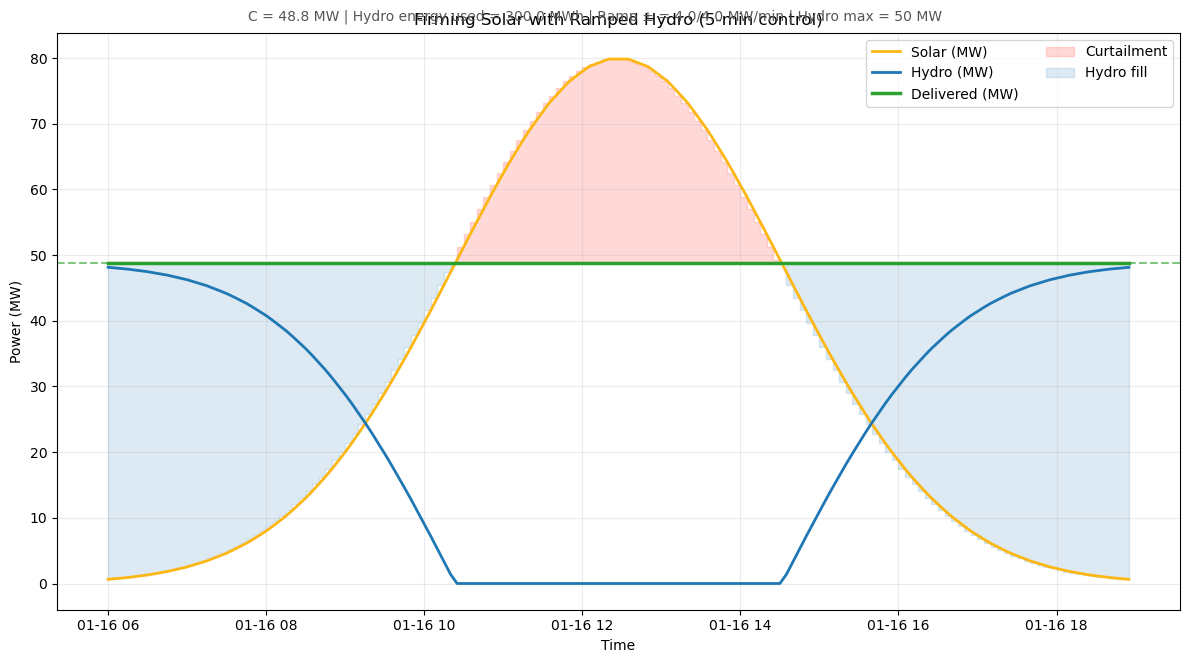

In [3]:

# ------------------------------ Example & Plot ------------------------------

if __name__ == "__main__":
    # Build a sample 15-min solar profile from 06:00 to 19:00 (inclusive-left)
    start = pd.Timestamp("2026-01-16 06:00")
    end = pd.Timestamp("2026-01-16 19:00")
    idx_15 = pd.date_range(start, end, freq="15min", inclusive="left")
    n15 = len(idx_15)

    # Synthetic bell-shaped solar (MW) peaking around noon
    x = np.linspace(-2.2, 2.2, n15)
    solar_15 = 80 * np.exp(-x**2)  # peak ~80 MW

    # Hydro constraints
    hydro_max_mw = 50.0
    hydro_energy_mwh_total = 300.0    # daily energy available (MWh), usable in this window
    ramp_up_mw_per_min = 4.0          # e.g., can ramp up 4 MW per minute
    ramp_dn_mw_per_min = 4.0          # symmetric ramp down
    initial_hydro_mw = None           # or set to a value, e.g., 0.0

    # Compute schedule at 5-min control
    result = compute_hydro_firming_ramped(
        solar_15,
        hydro_max_mw=hydro_max_mw,
        hydro_energy_mwh_total=hydro_energy_mwh_total,
        ramp_up_mw_per_min=ramp_up_mw_per_min,
        ramp_dn_mw_per_min=ramp_dn_mw_per_min,
        allow_curtailment=True,
        initial_hydro_mw=initial_hydro_mw,
        dt_control_min=5
    )

    # Build a 5-min time index to match outputs
    idx_5 = pd.date_range(start, end, freq="5min", inclusive="left")
    solar_5 = resample_to_5min(solar_15)

    # Unpack results
    C = result["firm_power_mw"]
    hydro = result["hydro_mw"]
    delivered = result["delivered_mw"]
    curtail = result["curtailment_mw"]
    used_energy = result["used_hydro_energy_mwh"]

    # Diagnostics
    avg = delivered.mean()
    peak = delivered.max()
    load_factor = (avg / peak) if peak > 0 else np.nan

    print(f"Firm power (MW): {C:.3f}")
    print(f"Used hydro energy (MWh): {used_energy:.3f}  (Budget: {hydro_energy_mwh_total:.2f})")
    print(f"Ramp up/down (MW/min): {ramp_up_mw_per_min:.2f}/{ramp_dn_mw_per_min:.2f}")
    print(f"Hydro max (MW): {hydro_max_mw:.2f}")
    print(f"Load factor: {load_factor:.6f}")

    # ------------------------------ Plotting ------------------------------
    plt.figure(figsize=(12, 7))
    plt.plot(idx_5, solar_5, label="Solar (MW)", color="#FDB714", linewidth=2.0)
    plt.plot(idx_5, hydro, label="Hydro (MW)", color="#1F77B4", linewidth=2.0)
    plt.plot(idx_5, delivered, label="Delivered (MW)", color="#2CA02C", linewidth=2.5)

    # Flat setpoint line
    plt.axhline(C, color="#2CA02C", linestyle="--", alpha=0.6, linewidth=1.5)

    # Curtailment shading (solar above C)
    above = solar_5 > C + 1e-12
    if np.any(above):
        plt.fill_between(idx_5, C, solar_5, where=above, color="#FF6961", alpha=0.25, step="pre", label="Curtailment")

    # Gap shading (hydro fills up to C when solar below)
    below = solar_5 < C - 1e-12
    if np.any(below):
        plt.fill_between(idx_5, solar_5, np.minimum(C, solar_5 + hydro), where=below,
                         color="#1F77B4", alpha=0.15, step="pre", label="Hydro fill")

    plt.title("Firming Solar with Ramped Hydro (5-min control)")
    plt.xlabel("Time")
    plt.ylabel("Power (MW)")
    plt.grid(True, alpha=0.25)
    plt.legend(loc="upper right", ncol=2)
    subtitle = (f"C = {C:.1f} MW | Hydro energy used = {used_energy:.1f} MWh "
                f"| Ramp ± = {ramp_up_mw_per_min:.1f}/{ramp_dn_mw_per_min:.1f} MW/min "
                f"| Hydro max = {hydro_max_mw:.0f} MW")
    plt.suptitle(subtitle, y=0.94, fontsize=10, color="#555")
    plt.tight_layout()
    plt.show()